# Clustering

<style>
    .large-link {
        font-size: 30px;
        font-family: Arial, sans-serif;
        color: #333;
        text-decoration: none;
    }
</style>
<a href="../assets/pdf/08_clustering_day2.pdf" target="_blank" class="large-link">Download Presentation: Clustering</a>

In [1]:
import scanpy as sc
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package
import seaborn as sns # plotting package

**Exercise 0**: Before we continue in this notebook with the next steps of the analysis, we need to load our results from the previous notebook using the `sc.read_h5ad` function and assign them to the variable name `adata`. Give it a try!

<button onclick="toggleVisibility('answer0')">Click for Answer</button>
<div id="answer0" style="display:none;">
<strong>Answer:</strong> Load your data from the previous notebook into an h5ad object with <code>sc.read_h5ad</code>
<pre>
    adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial4.h5ad")
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

In [3]:
adata

AnnData object with n_obs × n_vars = 5465 × 3000
    obs: 'sample', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pcahm', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Clustering the data helps to identify cells with similar gene expression properties that may belong to the same cell type or cell state. There are two popular clustering methods, both available in scanpy: Louvain and Leiden clustering.

**Exercise 1**: Run Louvain and Leiden clustering algorithms. Visualize the clusters on your UMAP representation. Are the clusters different from each method?

<button onclick="toggleVisibility('answer1')">Click for Answer</button>
<div id="answer1" style="display:none;">
<strong>Answer:</strong>
<pre>
    sc.tl.louvain(adata)
    sc.tl.leiden(adata)
</pre>
    
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

Next, you can visualize your UMAP and tSNE representations of the scRNA-seq and color by various metadata attributes (including Louvian or Leiden clusters) from the prior steps. For example:

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


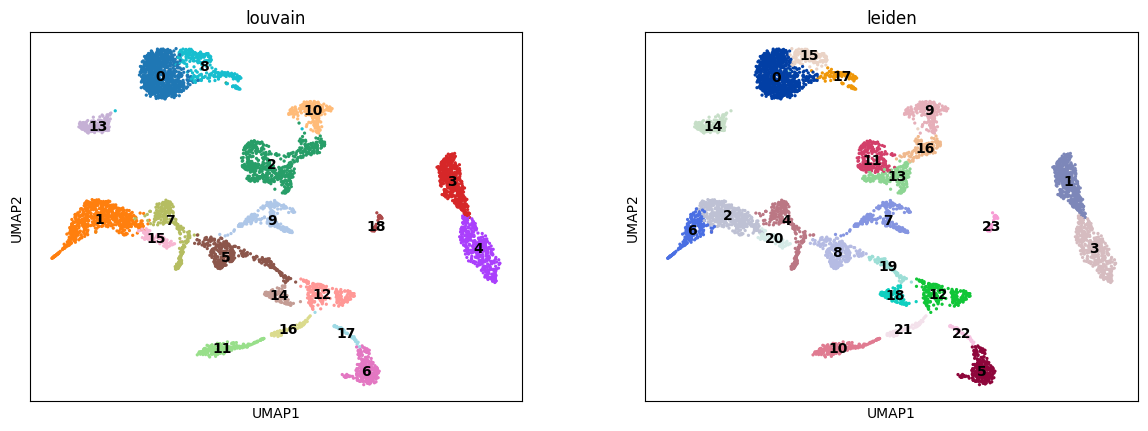

In [6]:
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

**Exercise 2**: Focus on the leiden clusters from this exercise and forward. How many cells do you have per cluster? Can you plot a histogram of this?

<button onclick="toggleVisibility('answer2')">Click for Answer</button>
<div id="answer2" style="display:none;">
<strong>Answer:</strong>
<pre>
    n_clusters = adata.obs["leiden"].value_counts()
    ax = n_clusters.plot(kind="bar")
    plt.show()
</pre>
    
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script> </div>

**Exercise 3**: Visualize some of the other metadata on the UMAP embedding, including the `n_counts`, `sample`, `n_genes`, `pct_counts_mt`, and `phase` metadata found in `adata.obs`. 

Do any clusters seem to have an obvious bias towards particular attributes? This might be a sign that we want to optimize prior steps of the analysis, such as adjusting the number of principal components used in the neighborhood smoothing or regressing out particular variables. As with a pandas dataframe, you can also examine the frequency of various attributes using a command such as: `adata.obs["phase"].value_counts()`.

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


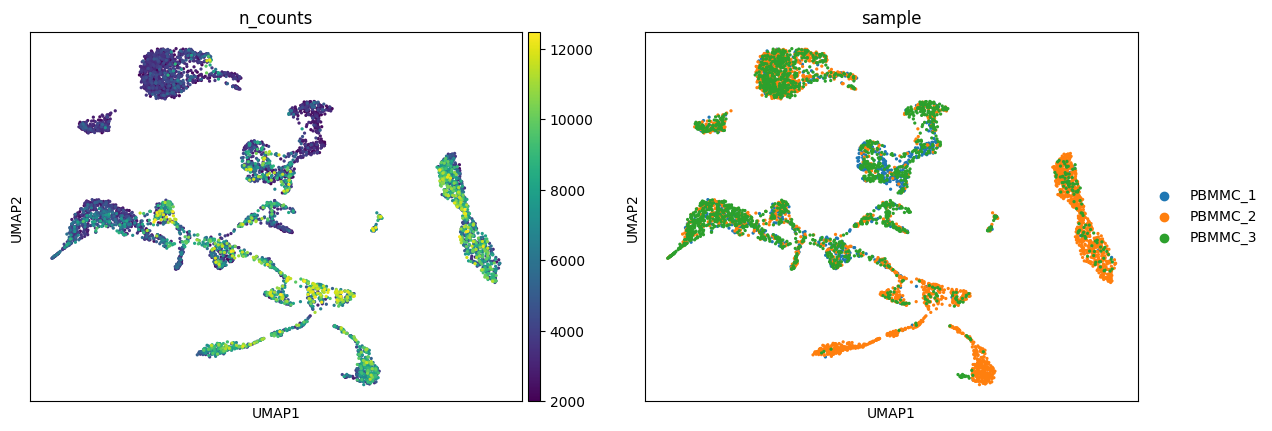

In [7]:
sc.pl.umap(adata, color=['n_counts', 'sample'])

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


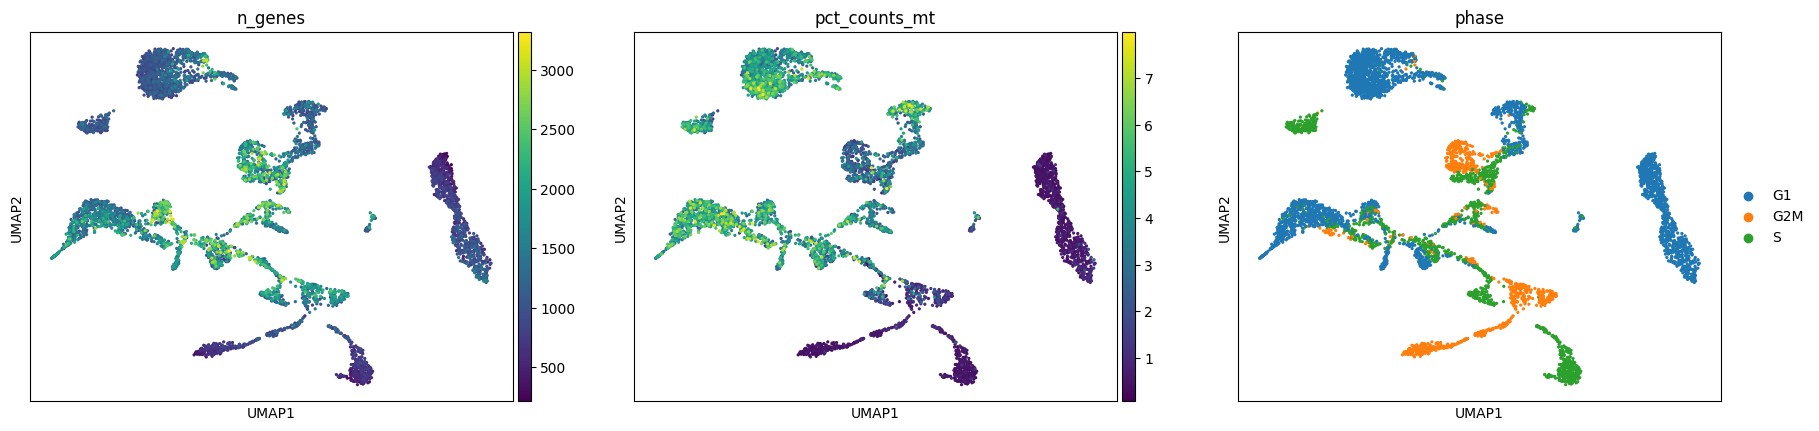

In [8]:
sc.pl.umap(adata, color=['n_genes', 'pct_counts_mt', 'phase'])

**Exercise 4**: Let’s proceed with Leiden clustering and UMAP embeddings for the time being.

- Create a new metadata attribute for your current clusters, i.e. `adata.obs["leiden_res1"] = adata.obs["leiden"]`.
- Repeat leiden clustering using different values for the resolution parameter: `0.1`, `0.5`, `2.0`.
- Save the clusters in a new metadata column and visualize them on the UMAP representation.
- How does the number of clusters change with adjustments to the resolution parameter? Using the resolution=1 as a basis, do any clusters divide into two smaller clusters upon changing the resolution parameter? Do any clusters merge together? Can you plot the three different clustering results side-by-side on the UMAP to compare?

In [9]:
adata.obs["leiden_res1"] = adata.obs["leiden"]

In [10]:
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


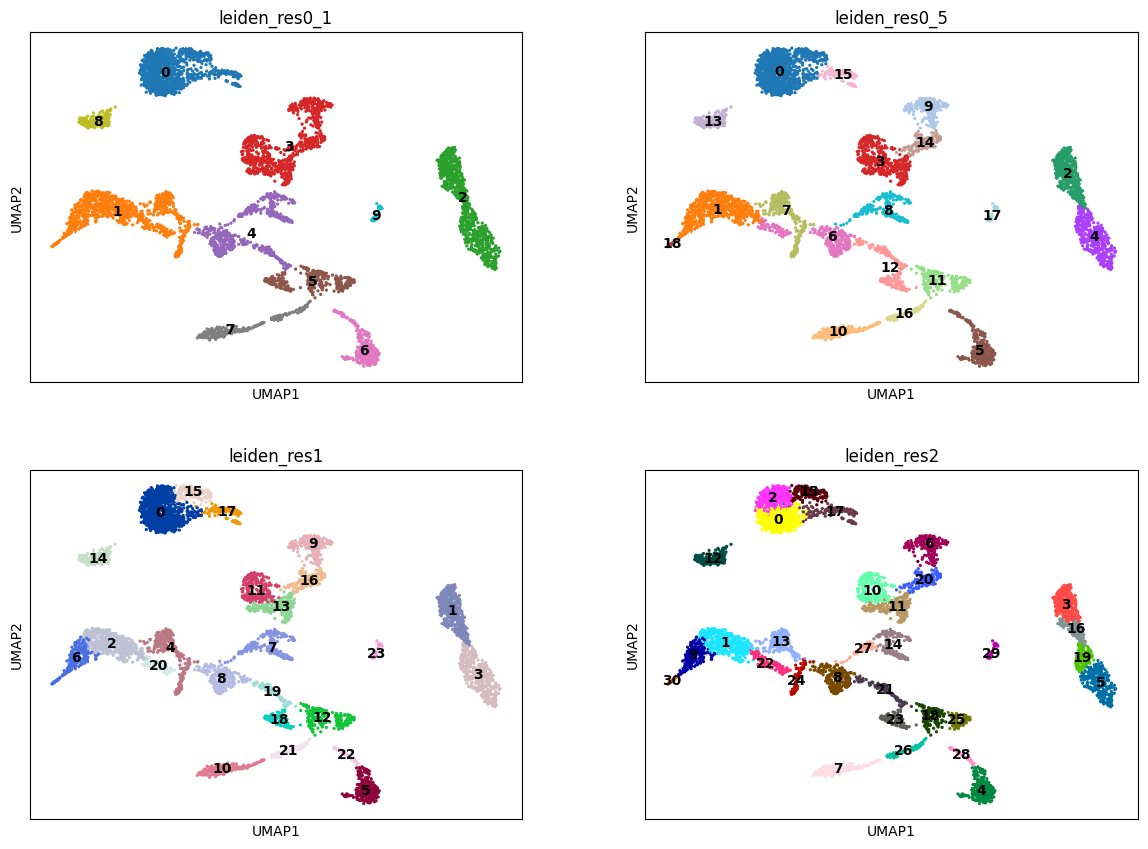

In [11]:
sc.pl.umap(
    adata,
    color=["leiden_res0_1", "leiden_res0_5", "leiden_res1", "leiden_res2"],
    legend_loc="on data",
    ncols=2,
)

In [13]:
adata.write_h5ad("PBMC_analysis_SIB_tutorial5.h5ad")